In [85]:
# импорт библиотек

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16, 7]

# Шаг 1. Подготовка данных

*Создал табличку в гугле, создаю подключение*

https://docs.google.com/spreadsheets/d/1IEwr-Bdh72S3_IwRzFwHr8PxSx_Gx3uhp44yYMhpKgQ/edit?usp=sharing

In [86]:
con = sqlite3.connect('db')

In [87]:
id = '1IEwr-Bdh72S3_IwRzFwHr8PxSx_Gx3uhp44yYMhpKgQ'

In [88]:
# Читаем данные

In [89]:
df = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{id}/export?format=csv')

In [90]:
df

,adv_name,sale,view_count,click_count,first_month_clients_count,second_month_clients_count,third_month_clients_count,first_month_orders_count,first_month_aov,second_month_aov,third_month_aov
0,А_android,500,3000000,25130,1560,374,78,345,8425,"4212,5","4212,5"
1,Б_iphone,800,3000000,23750,1345,94,27,285,10875,"5437,5","5437,5"


In [91]:
df.dtypes

adv_name                      object
sale                           int64
view_count                     int64
click_count                    int64
first_month_clients_count      int64
second_month_clients_count     int64
third_month_clients_count      int64
first_month_orders_count       int64
first_month_aov                int64
second_month_aov              object
third_month_aov               object
dtype: object

In [92]:
df.to_sql('test',con,index=False,if_exists='replace')

2

In [93]:
def select(sql):
    return pd.read_sql(sql,con)

In [94]:
sql = '''
    select *
    from test
    '''
select(sql)

,adv_name,sale,view_count,click_count,first_month_clients_count,second_month_clients_count,third_month_clients_count,first_month_orders_count,first_month_aov,second_month_aov,third_month_aov
0,А_android,500,3000000,25130,1560,374,78,345,8425,"4212,5","4212,5"
1,Б_iphone,800,3000000,23750,1345,94,27,285,10875,"5437,5","5437,5"


# Для анализа буду использовать pandas, хотя все то же самое могу сделать и через встроенный sqlite3 или создать БД на postgres, подключиться к ней и селектить так же в юпитере

# Шаг 2. Постановка задачи

### Analysis directions:

1. Какой вариант баннера оказался лучше в первый месяц?
2. Какие метрики показывают это?
3. Подтвердилась ли гипотеза, что повышенная скидка на первый заказ для пользователей iPhone принесет больше продаж по результатам первого месяца?
4. Какая когорта клиентов, установивших приложение в первый месяц, более ценная для маркетплейса по результатам трех месяцев - это клиенты с  iPhone или с Android?


* Когорта А_android, рекламная компания для пользователей Google play
* Когорта Б_iphone, рекламная компания для пользователей App Store

# Шаг 3. Анализ

In [95]:
# 1. Какой вариант баннера оказался лучше в первый месяц?
# 2. Какие метрики показывают это?

Основные метрики для рекламных компаний: CR, CTR, CPC, CPA, CPL, CAC. Рассчитаем некоторые из них:

In [96]:
# first month CTR and click-to-order CR

df = df.assign(first_month_ctr = df.click_count / df.view_count * 100)
df = df.assign(first_month_cr = df.first_month_orders_count / df.click_count * 100)
df

,adv_name,sale,view_count,click_count,first_month_clients_count,second_month_clients_count,third_month_clients_count,first_month_orders_count,first_month_aov,second_month_aov,third_month_aov,first_month_ctr,first_month_cr
0,А_android,500,3000000,25130,1560,374,78,345,8425,"4212,5","4212,5",0.837667,1.372861
1,Б_iphone,800,3000000,23750,1345,94,27,285,10875,"5437,5","5437,5",0.791667,1.200000


In [97]:
ctr_cr_data = df[['adv_name','first_month_ctr','first_month_cr']]
ctr_cr_data

,adv_name,first_month_ctr,first_month_cr
0,А_android,0.837667,1.372861
1,Б_iphone,0.791667,1.200000


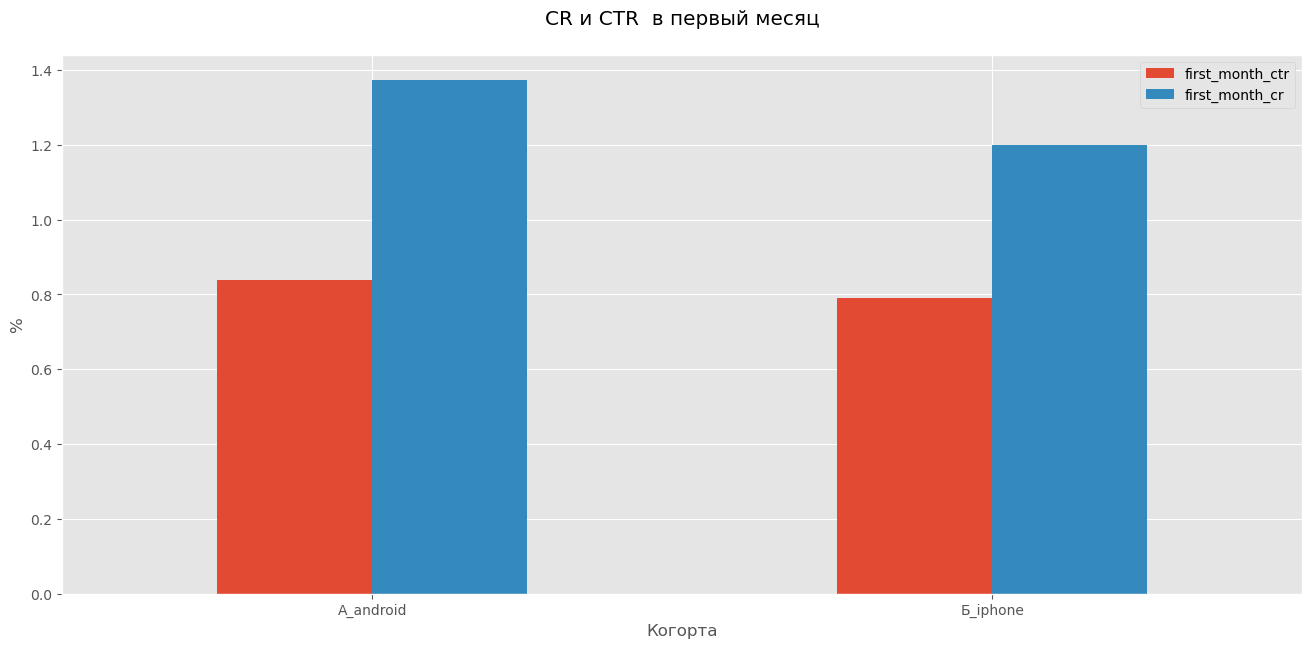

In [98]:
ctr_cr_data.set_index('adv_name') \
    .plot(kind='bar', title = 'CR и CTR  в первый месяц\n')
plt.ylabel("%")
plt.xlabel("Когорта")
plt.xticks(rotation=0)
plt.show()

In [99]:
# CTR и конверсия из клика в заказ когорты A в первый месяц выше. 
# Теперь оценим суммарный доход за первый месяц.


In [100]:
df = df.assign(first_month_revenue = df.first_month_orders_count * (df.first_month_aov - df.sale))
df[['adv_name','first_month_revenue']]

,adv_name,first_month_revenue
0,А_android,2734125
1,Б_iphone,2871375


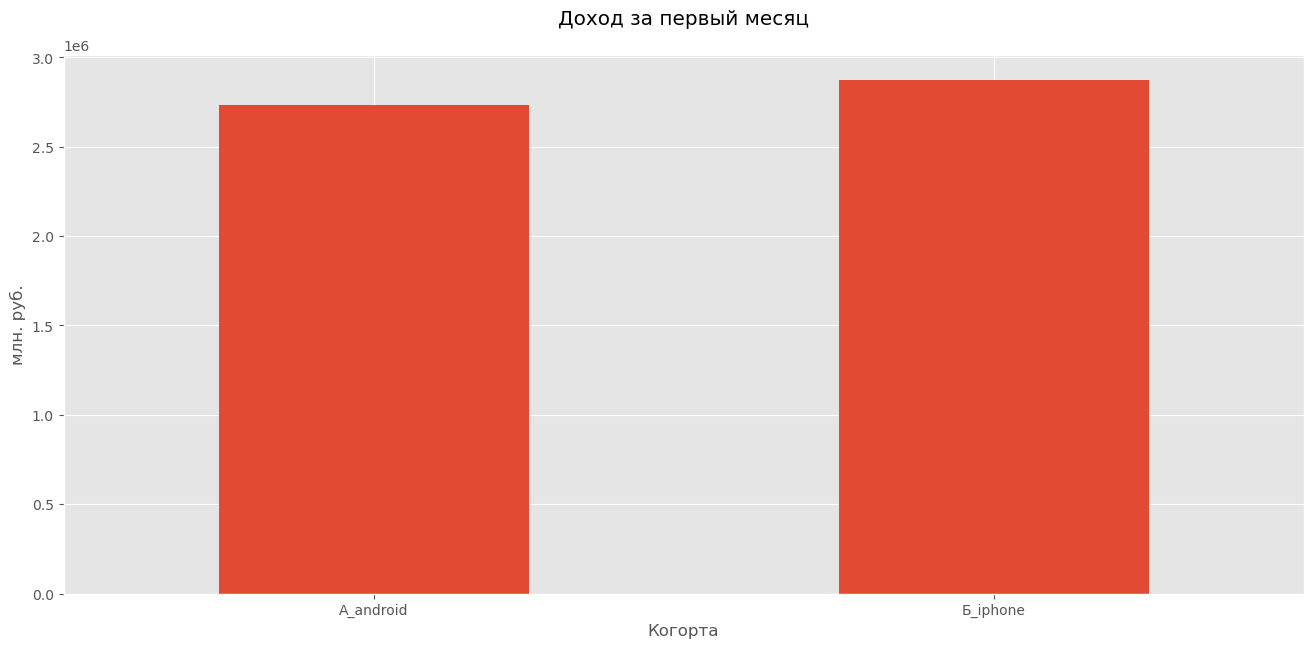

In [101]:
ax = df[['adv_name','first_month_revenue']].set_index('adv_name') \
    .plot(kind='bar', title = 'Доход за первый месяц\n',legend=False)
plt.ylabel("млн. руб.")
plt.xlabel("Когорта")
plt.xticks(rotation=0)
plt.show()

#### Наблюдения :
* Когорта А имеет лучший CTR
* Когорта А имеет лучший показатель конверсии из клика в установку приложения, из клика в заказ
* Когорта Б принесла больший доход
* При допущении, что стоимость размещения баннеров для обеих когорт была одинаковой, Когорта Б имеет меньшую стоиомсть клика
 

In [102]:
# Какая когорта клиентов, установивших приложение в первый месяц, более ценная для маркетплейса
# по результатам трех месяцев - это клиенты с iPhone или с Android?


##### Оценим суммарный доход от когорт за 3 месяца.

Учтем скидку за первый заказ при подсчете дохода за первый месяц и дальнейшее снижение среднего чека во 2 и 3 месяцы, а так же то, что нам известно, что конверсия вернувшихся в приложение пользователей осталась стабильной 

- рассчитаем предполагаемое кол-во заказов для 2 и 3 месяца по нашим когортам

In [103]:
df = df \
    .assign(second_month_orders_count = \
    (df.second_month_clients_count * (df.first_month_orders_count / df.first_month_clients_count))) \
    .round()
df = df \
    .assign(third_month_orders_count = \
    (df.third_month_clients_count * (df.first_month_orders_count / df.first_month_clients_count))) \
    .round()
df[['adv_name','first_month_clients_count','second_month_clients_count','third_month_clients_count']].set_index('adv_name')

,first_month_clients_count,second_month_clients_count,third_month_clients_count
adv_name,,,
А_android,1560,374,78
Б_iphone,1345,94,27


In [104]:
# заменим запятые в колонках со средним чеком за 2 и 3 месяц на точки

In [105]:
df.second_month_aov = df.second_month_aov.str.replace(',','.')
df.third_month_aov = df.third_month_aov.str.replace(',','.')
df.second_month_aov = pd.to_numeric(df.second_month_aov)
df.third_month_aov = pd.to_numeric(df.third_month_aov)

In [59]:
df

,adv_name,sale,view_count,click_count,first_month_clients_count,second_month_clients_count,third_month_clients_count,first_month_orders_count,first_month_aov,second_month_aov,third_month_aov,first_month_ctr,first_month_cr,first_month_revenue,second_month_orders_count,third_month_orders_count
0,А_android,500,3000000,25130,1560,374,78,345,8425,4212.5,4212.5,1.0,1.0,2734125,83.0,17.0
1,Б_iphone,800,3000000,23750,1345,94,27,285,10875,5437.5,5437.5,1.0,1.0,2871375,20.0,6.0


In [27]:
# Рассчитаем предполагаемый доход за 2 и 3 месяц по когортам

df = df.assign(second_month_revenue = df.second_month_orders_count * df.second_month_aov)
df = df.assign(third_month_revenue = df.third_month_orders_count * df.third_month_aov)
df = df.assign(total_revenue = df.first_month_revenue + df.second_month_revenue + df.third_month_revenue)


In [28]:
revenue_data = df[['adv_name', 'first_month_revenue', 'second_month_revenue', 'third_month_revenue', 'total_revenue']] \
    .set_index('adv_name')
revenue_data

,first_month_revenue,second_month_revenue,third_month_revenue,total_revenue
adv_name,,,,
А_android,2734125,349637.5,71612.5,3155375.0
Б_iphone,2871375,108750.0,32625.0,3012750.0


In [29]:
# Видим, что суммарно за 3 месяца пользователи когорты А принесли больше денег, чем пользователи из когорты Б

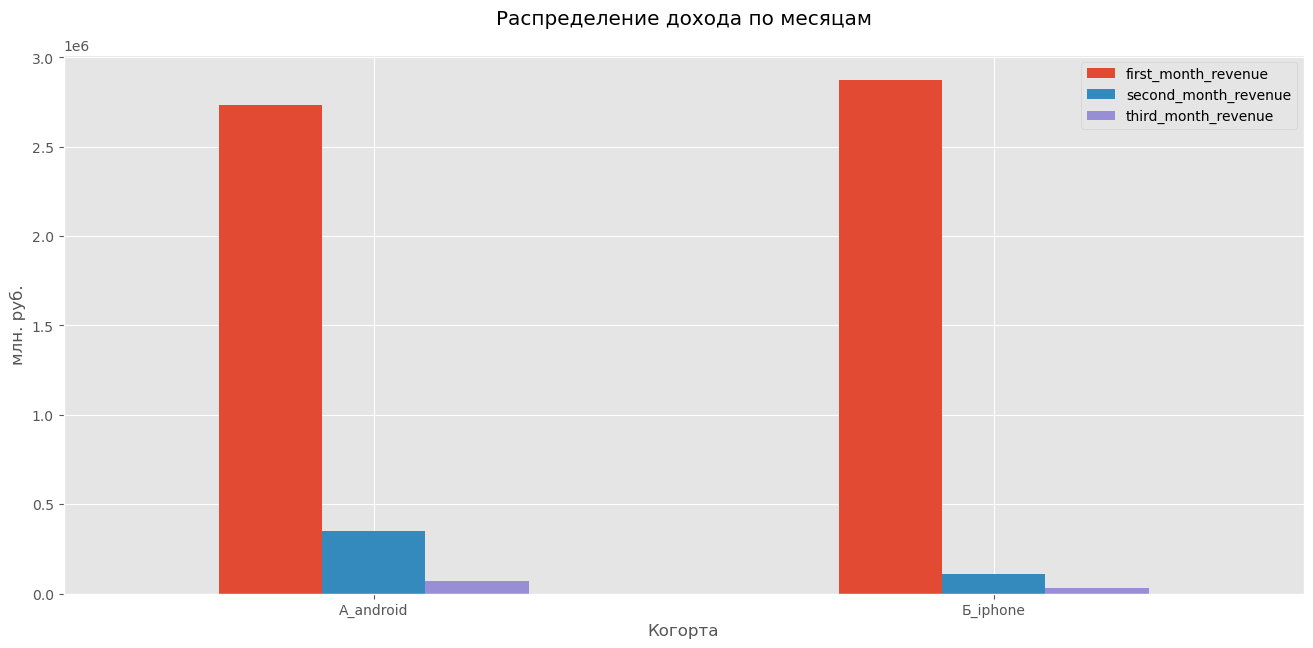

In [30]:
revenue_data[[ 'first_month_revenue', 'second_month_revenue', 'third_month_revenue']] \
    .plot(kind='bar', title = 'Распределение дохода по месяцам\n')
plt.ylabel("млн. руб.")
plt.xlabel("Когорта")
plt.xticks(rotation=0)
plt.show()


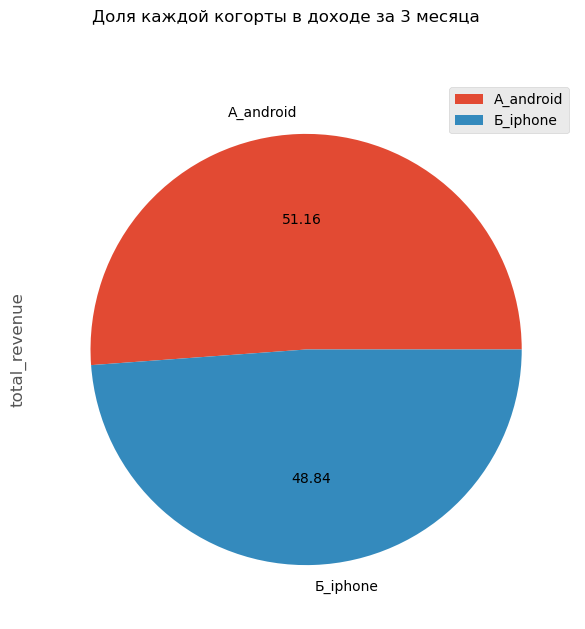

In [31]:
revenue_data[[ 'total_revenue']] \
    .plot(kind='pie', title = 'Доля каждой когорты в доходе за 3 месяца\n',subplots=True,
    autopct="%.2f"
    )
plt.show()

#### Видим, что за три месяца :
* когорта А принесла доход больше, чем когорта Б
* доход во второй и третий месяц значительно снижается в обеих когортах
* несмотря на меньший доход в первом месяце на дистанции в 3 месяца более выгодной оказался баннер для android


#### Выводы :
1. Какой вариант баннера оказался лучше в первый месяц? - Вариант Б, баннер для iphone
2. Какие метрики показывают это? total revenue. Конверсия на всех этапах воронки выше в когорте А, но средний чек сыграл важную роль и даже несмотря на большую скидку, пользователи с iphone принесли больший доход за 1 месяц
3. Подтвердилась ли гипотеза, что повышенная скидка на первый заказ для пользователей iphone принесет больше продаж по результатам первого месяца? - Подтвердилась 
4. Какая когорта клиентов, установивших приложение в первый месяц, более ценная для маркетплейса по результатам трех месяцев - это клиенты с  iPhone или с Android? - На дистанции в 3 месяца чуть более выгодной стала когорта А пользоватлей android

In [36]:
df.to_csv('tvil-test.csv')

In [58]:
df

,adv_name,sale,view_count,click_count,first_month_clients_count,second_month_clients_count,third_month_clients_count,first_month_orders_count,first_month_aov,second_month_aov,third_month_aov,first_month_ctr,first_month_cr,first_month_revenue,second_month_orders_count,third_month_orders_count
0,А_android,500,3000000,25130,1560,374,78,345,8425,4212.5,4212.5,1.0,1.0,2734125,83.0,17.0
1,Б_iphone,800,3000000,23750,1345,94,27,285,10875,5437.5,5437.5,1.0,1.0,2871375,20.0,6.0
